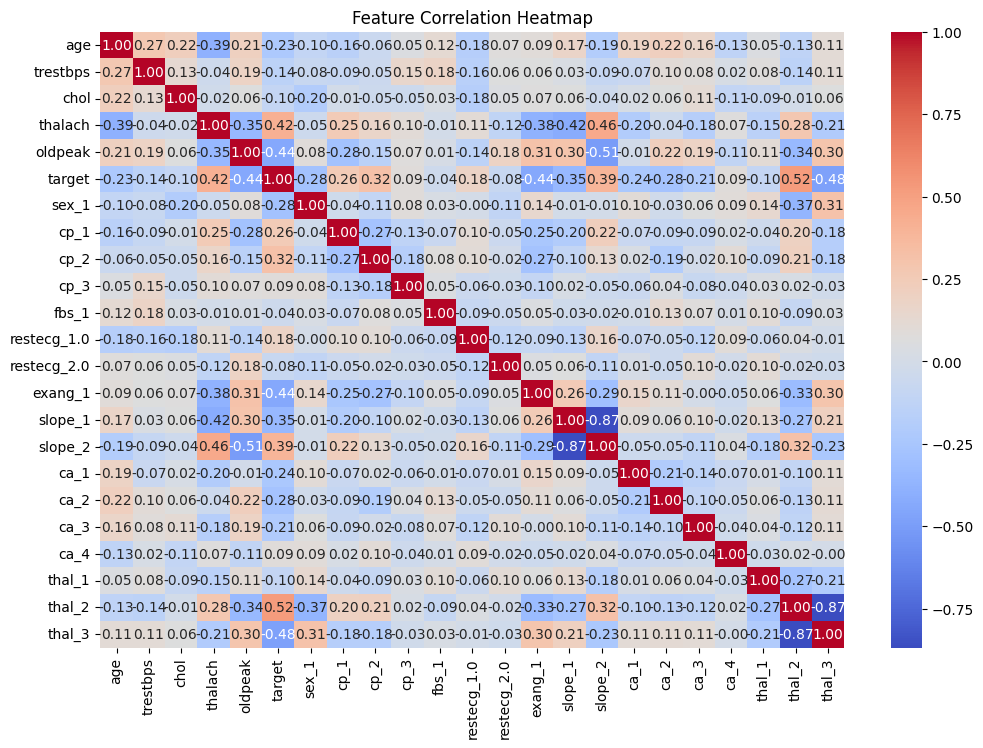

Cleaned data saved as cleaned_data.csv


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Load Dataset
def load_dataset(filename):
    """Loads the heart disease dataset."""
    return pd.read_csv(filename)

# Handle Missing Values
def handle_missing_values(df):
    """Fills missing values with median or drops rows if necessary."""
    df.fillna(df.median(numeric_only=True), inplace=True)
    return df

# Normalize Data
def normalize_data(df, numerical_features):
    """Scales numerical features using MinMaxScaler."""
    existing_features = [col for col in numerical_features if col in df.columns]
    if not existing_features:
        raise ValueError("No valid numerical features found!")
    
    scaler = MinMaxScaler()
    df[existing_features] = scaler.fit_transform(df[existing_features])
    return df

# Encode Categorical Variables
def encode_categorical(df, categorical_features):
    """Encodes categorical features using One-Hot Encoding."""
    df = pd.get_dummies(df, columns=[col for col in categorical_features if col in df.columns], drop_first=True)
    return df

# Feature Selection
def feature_selection(df):
    """Performs correlation analysis to identify important features."""
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Feature Correlation Heatmap")
    plt.show()
    return df

# Save Cleaned Data
def save_cleaned_data(df, filename="cleaned_data.csv"):
    """Saves the processed dataset to a CSV file."""
    df.to_csv(filename, index=False)
    print(f"Cleaned data saved as {filename}")

# Main Function
def main():
    filename = "heart.csv"
    df = load_dataset(filename)
    
    numerical_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]
    categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
    
    df = handle_missing_values(df)
    df = normalize_data(df, numerical_features)
    df = encode_categorical(df, categorical_features)
    df = feature_selection(df)
    save_cleaned_data(df)

if __name__ == "__main__":
    main()

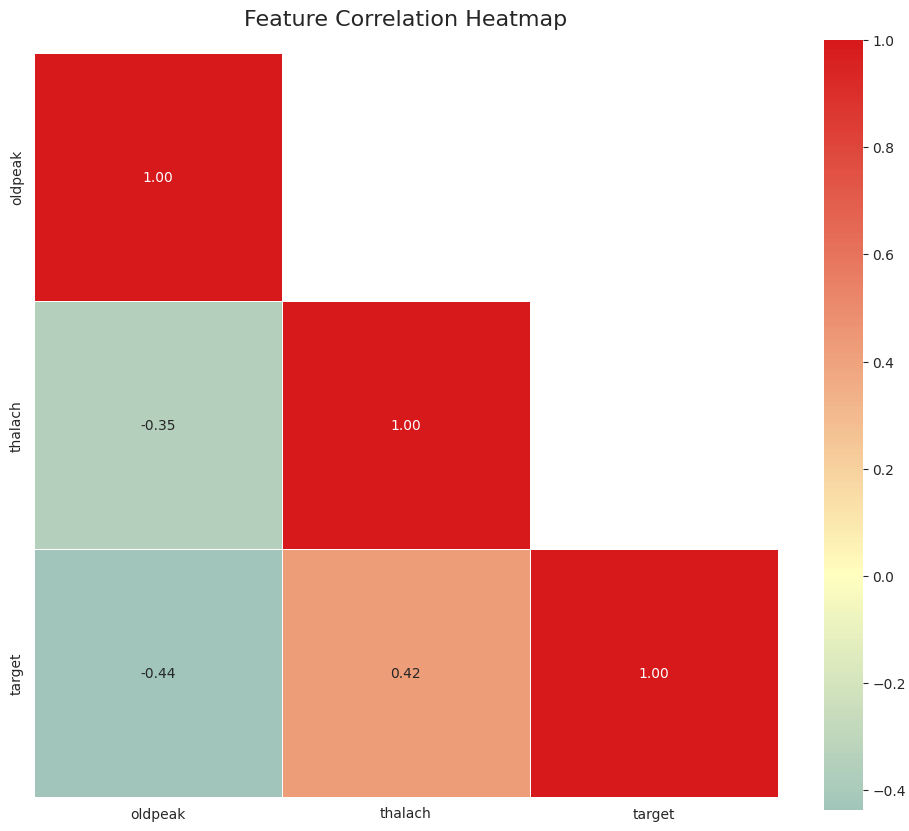

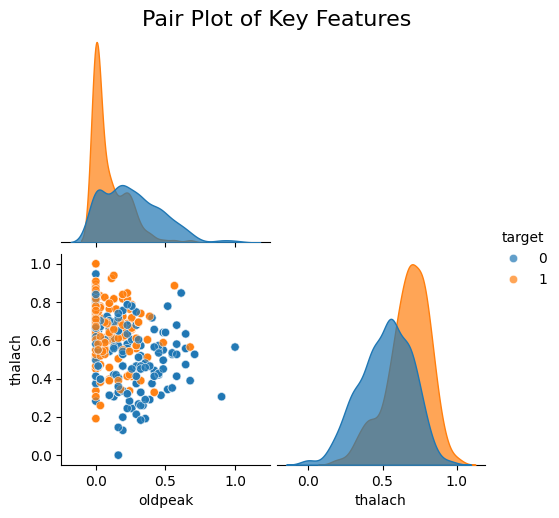

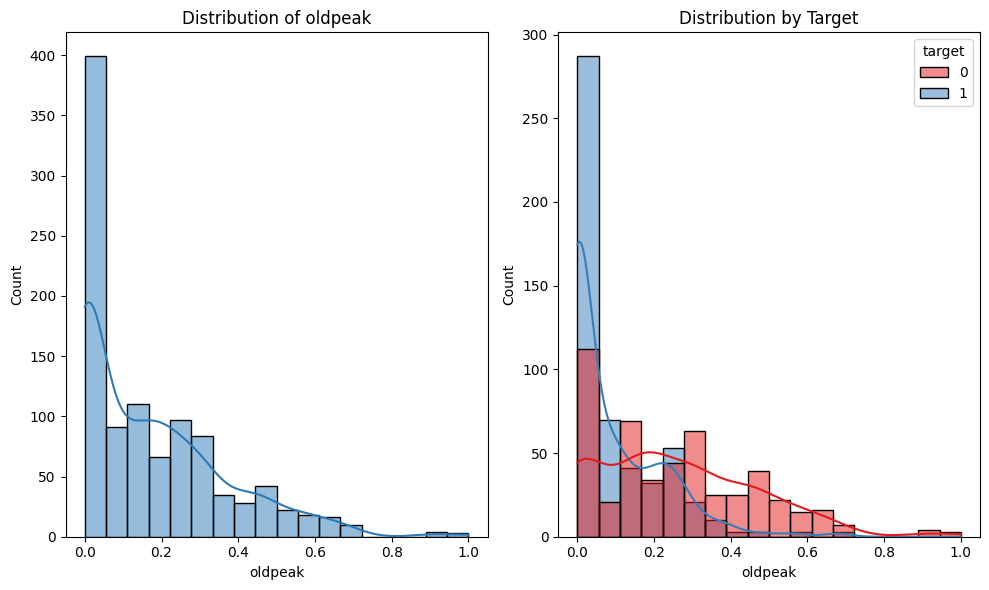

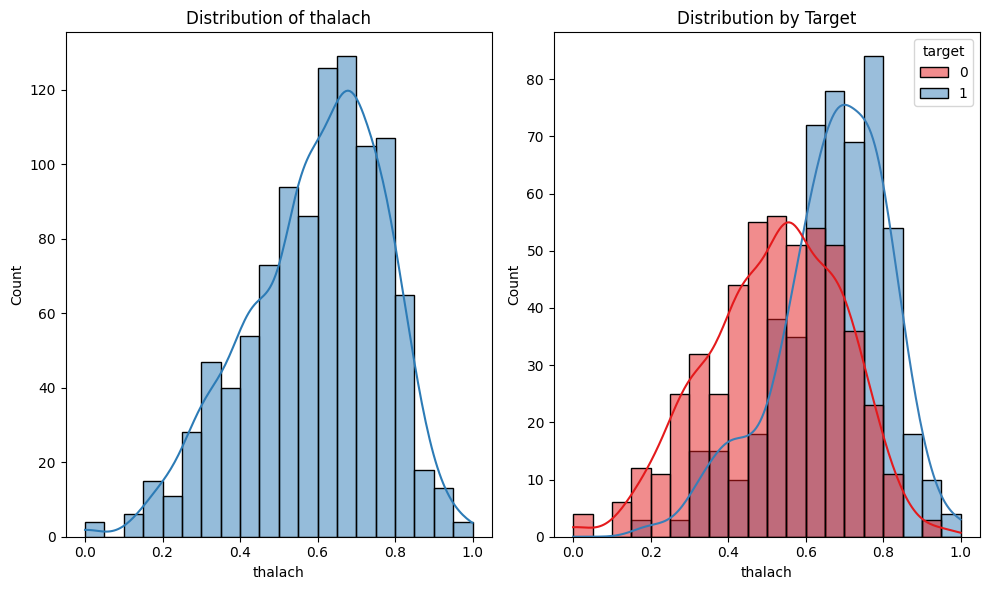

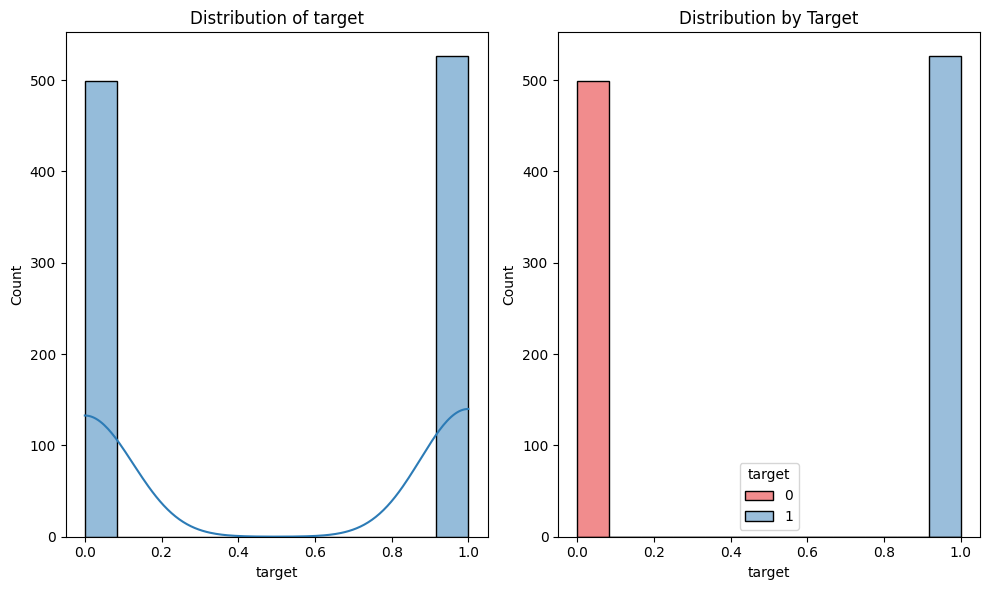

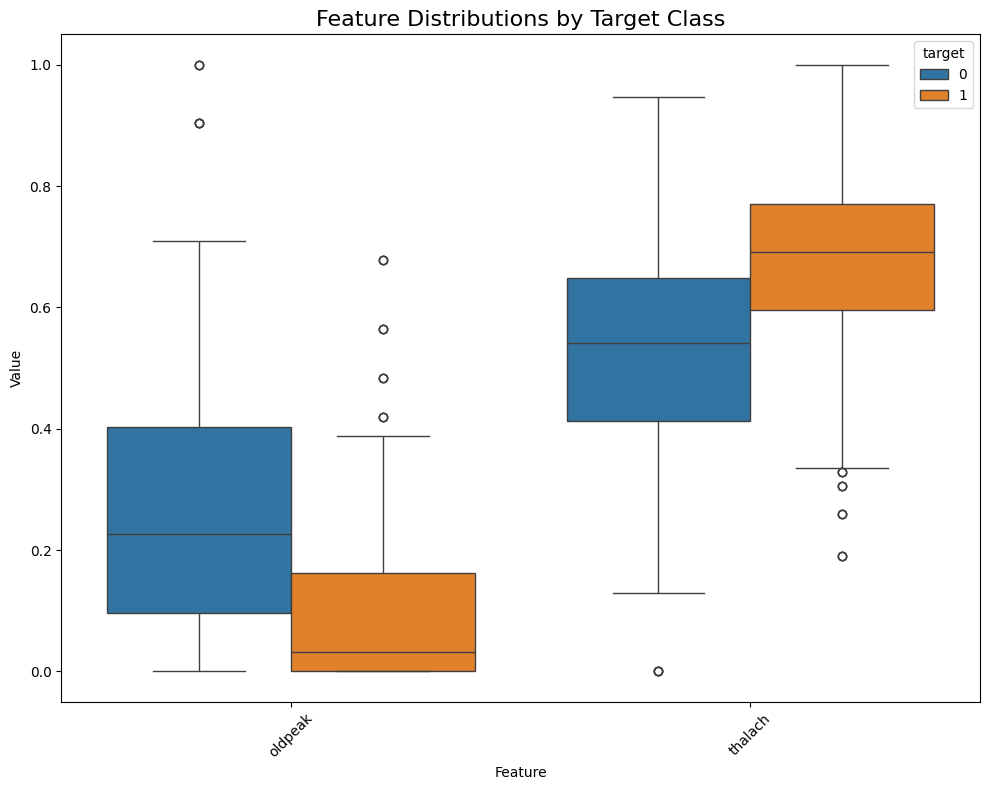

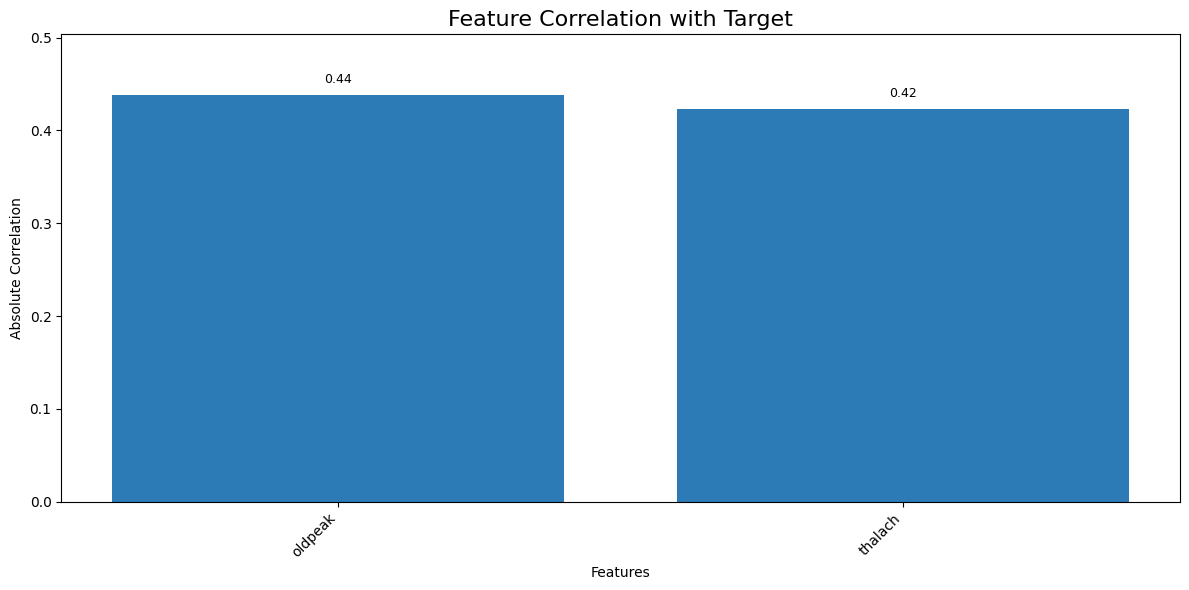

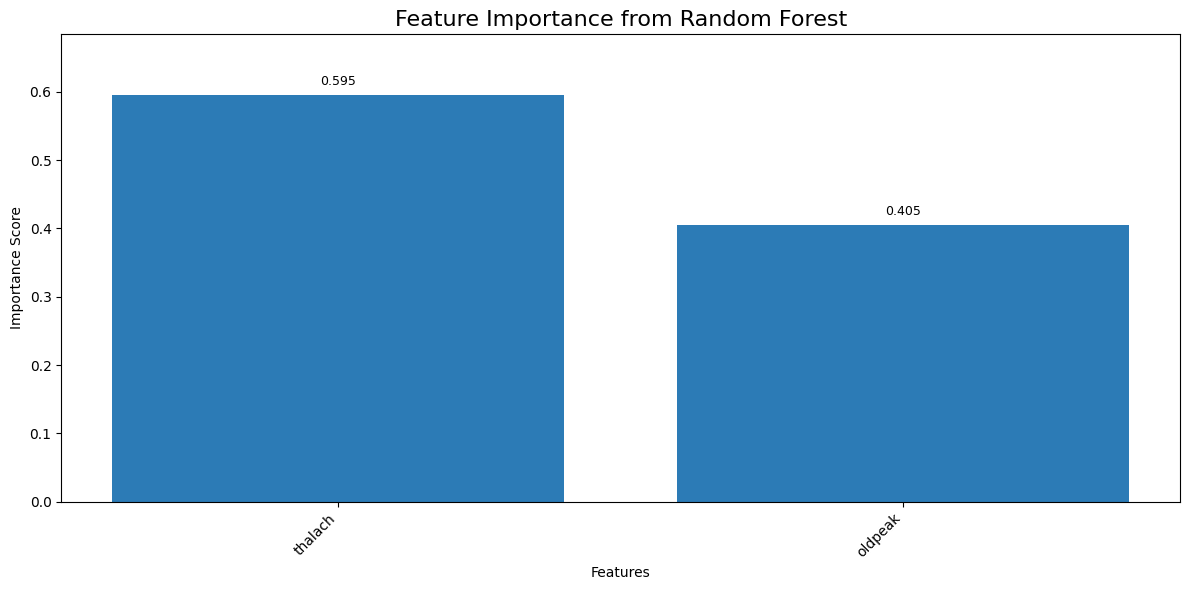

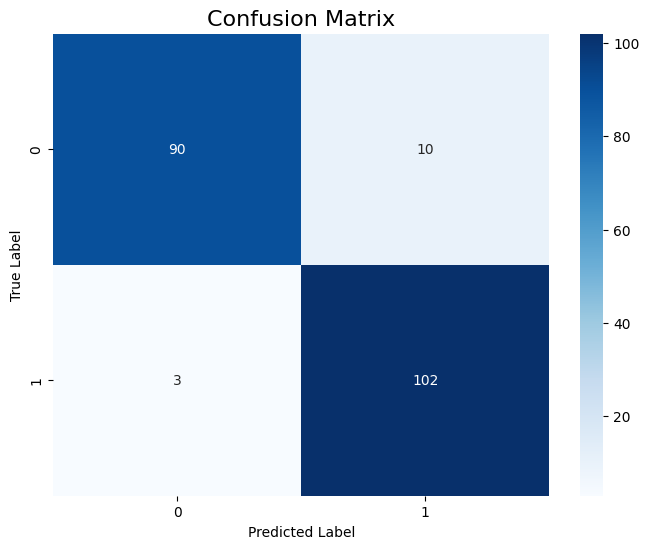

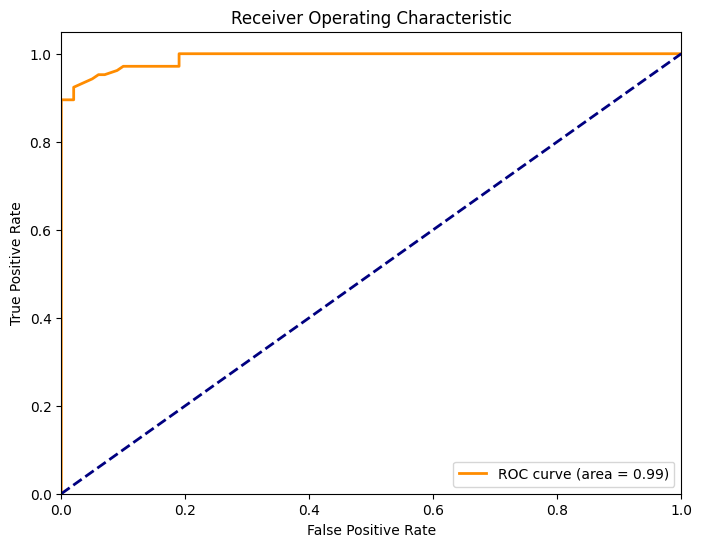

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import os
import warnings
from matplotlib.colors import LinearSegmentedColormap
import logging

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("heart_analysis.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger("heart_analysis")

# Suppress warnings
warnings.filterwarnings('ignore')

def is_notebook():
    """Check if we're running in a Jupyter notebook"""
    try:
        from IPython import get_ipython
        if get_ipython() is None:
            return False
        if 'IPKernelApp' not in get_ipython().config:
            return False
        return True
    except ImportError:
        return False

# Custom colormap for better visualization
heart_cmap = LinearSegmentedColormap.from_list('heart_colors', ['#2c7bb6', '#ffffbf', '#d7191c'])

# Load Dataset
def load_dataset(filename):
    """
    Loads the dataset if it exists and performs basic validation.
    
    Args:
        filename (str): Path to the CSV file
    
    Returns:
        pd.DataFrame: Loaded dataset
    """
    try:
        if not os.path.exists(filename):
            raise FileNotFoundError(f"File '{filename}' not found.")
        
        df = pd.read_csv(filename)
        
        if df.empty:
            raise ValueError("Dataset is empty")
            
        logger.info(f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")
        return df
    
    except Exception as e:
        logger.error(f"Error loading dataset: {str(e)}")
        raise

# Basic Data Summary
def summarize_data(df):
    """
    Provides a comprehensive summary of the dataset.
    
    Args:
        df (pd.DataFrame): Input dataset
        
    Returns:
        dict: Summary statistics
    """
    summary = {}
    
    try:
        # Basic info
        summary['shape'] = df.shape
        summary['columns'] = df.columns.tolist()
        summary['dtypes'] = df.dtypes.to_dict()
        
        # Missing values
        missing_values = df.isnull().sum()
        if missing_values.sum() > 0:
            summary['missing_values'] = missing_values[missing_values > 0].to_dict()
        else:
            summary['missing_values'] = "No missing values"
            
        # Basic statistics
        summary['numeric_stats'] = df.describe().to_dict()
        
        # Categorical columns summary
        cat_cols = df.select_dtypes(include=['object', 'category']).columns
        if not cat_cols.empty:
            summary['categorical_summary'] = {col: df[col].value_counts().to_dict() for col in cat_cols}
            
        if 'target' in df.columns:
            summary['target_distribution'] = df['target'].value_counts().to_dict()
            
        logger.info("Data summary generated successfully")
        return summary
        
    except Exception as e:
        logger.error(f"Error generating data summary: {str(e)}")
        return {"error": str(e)}

# Handle Missing Values
def handle_missing_values(df, strategy='median_mode'):
    """
    Fills missing values based on the selected strategy.
    
    Args:
        df (pd.DataFrame): Input dataset
        strategy (str): Strategy for handling missing values
                        'median_mode': median for numeric, mode for categorical
                        'mean_mode': mean for numeric, mode for categorical
                        'drop': drop rows with missing values
    
    Returns:
        pd.DataFrame: Dataset with handled missing values
    """
    try:
        # Make a copy to avoid modifying the original
        df_clean = df.copy()
        
        # Check for missing values
        missing_count = df_clean.isnull().sum().sum()
        if missing_count == 0:
            logger.info("No missing values found in the dataset")
            return df_clean
            
        logger.info(f"Found {missing_count} missing values. Applying strategy: {strategy}")
        
        if strategy == 'drop':
            initial_rows = df_clean.shape[0]
            df_clean = df_clean.dropna()
            dropped_rows = initial_rows - df_clean.shape[0]
            logger.info(f"Dropped {dropped_rows} rows with missing values")
            
        elif strategy in ['median_mode', 'mean_mode']:
            for col in df_clean.columns:
                if df_clean[col].isnull().sum() > 0:
                    if df_clean[col].dtype in ['int64', 'float64']:
                        if strategy == 'median_mode':
                            fill_value = df_clean[col].median()
                            method = 'median'
                        else:
                            fill_value = df_clean[col].mean()
                            method = 'mean'
                    else:
                        # For categorical columns, use mode
                        if df_clean[col].mode().empty:
                            fill_value = "Unknown"
                        else:
                            fill_value = df_clean[col].mode()[0]
                        method = 'mode'
                        
                    df_clean[col].fillna(fill_value, inplace=True)
                    logger.info(f"Filled {col} missing values with {method}")
        else:
            raise ValueError(f"Unknown strategy: {strategy}. Use 'median_mode', 'mean_mode', or 'drop'")
            
        return df_clean
        
    except Exception as e:
        logger.error(f"Error handling missing values: {str(e)}")
        raise

# Normalize Data
def normalize_data(df, numerical_features, method='minmax'):
    """
    Scales numerical features using the specified method.
    
    Args:
        df (pd.DataFrame): Input dataset
        numerical_features (list): List of numerical feature names
        method (str): Scaling method ('minmax' or 'standard')
    
    Returns:
        pd.DataFrame: Dataset with normalized features
        dict: Fitted scalers for each feature (useful for transforming new data)
    """
    try:
        # Make a copy to avoid modifying the original
        df_scaled = df.copy()
        
        # Verify numerical features exist in the dataframe
        existing_features = [col for col in numerical_features if col in df.columns]
        if not existing_features:
            raise ValueError("No valid numerical features found!")
            
        logger.info(f"Normalizing {len(existing_features)} numerical features using {method}")
        
        # Initialize the appropriate scaler
        if method.lower() == 'minmax':
            scaler = MinMaxScaler()
        elif method.lower() == 'standard':
            scaler = StandardScaler()
        else:
            raise ValueError(f"Unknown scaling method: {method}. Use 'minmax' or 'standard'")
        
        # Apply scaling
        df_scaled[existing_features] = scaler.fit_transform(df[existing_features])
        
        return df_scaled, scaler
        
    except Exception as e:
        logger.error(f"Error normalizing data: {str(e)}")
        raise

# Encode Categorical Variables
def encode_categorical(df, categorical_features, method='onehot'):
    """
    Encodes categorical features using specified method.
    
    Args:
        df (pd.DataFrame): Input dataset
        categorical_features (list): List of categorical feature names
        method (str): Encoding method ('onehot' or 'label')
    
    Returns:
        pd.DataFrame: Dataset with encoded features
    """
    try:
        # Make a copy to avoid modifying the original
        df_encoded = df.copy()
        
        # Verify categorical features exist in the dataframe
        existing_features = [col for col in categorical_features if col in df.columns]
        if not existing_features:
            logger.warning("No valid categorical features found!")
            return df_encoded
            
        logger.info(f"Encoding {len(existing_features)} categorical features using {method}")
        
        if method.lower() == 'onehot':
            df_encoded = pd.get_dummies(df_encoded, columns=existing_features, drop_first=True)
            logger.info(f"One-hot encoding expanded features from {len(df.columns)} to {len(df_encoded.columns)}")
        elif method.lower() == 'label':
            from sklearn.preprocessing import LabelEncoder
            encoder = LabelEncoder()
            for col in existing_features:
                df_encoded[col] = encoder.fit_transform(df_encoded[col].astype(str))
            logger.info(f"Label encoding completed for {len(existing_features)} features")
        else:
            raise ValueError(f"Unknown encoding method: {method}. Use 'onehot' or 'label'")
            
        return df_encoded
        
    except Exception as e:
        logger.error(f"Error encoding categorical features: {str(e)}")
        raise

# Feature Selection
def select_top_features(df, target_column="target", top_n=10, method='correlation'):
    """
    Selects top features based on the specified method.
    
    Args:
        df (pd.DataFrame): Input dataset
        target_column (str): Target column name
        top_n (int): Number of top features to select
        method (str): Feature selection method ('correlation' or 'forest')
    
    Returns:
        list: Selected feature names
    """
    try:
        if target_column not in df.columns:
            raise ValueError(f"Target column '{target_column}' not found in the dataframe")
            
        # Ensure we don't try to select more features than available
        available_features = len(df.columns) - 1  # Exclude target column
        top_n = min(top_n, available_features)
        
        logger.info(f"Selecting top {top_n} features using {method} method")
        
        if method.lower() == 'correlation':
            corr = df.corr()[target_column].abs().sort_values(ascending=False)
            selected_features = corr.index[1:top_n + 1].tolist()  # Exclude target itself
            
        elif method.lower() == 'forest':
            X = df.drop(columns=[target_column])
            y = df[target_column]
            X = X.select_dtypes(include=['number'])  # Only numeric features
            
            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            rf.fit(X, y)
            
            feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
            selected_features = feature_importances.sort_values(
                ascending=False).head(top_n).index.tolist()
                
        else:
            raise ValueError(f"Unknown selection method: {method}. Use 'correlation' or 'forest'")
            
        if not selected_features:
            raise ValueError("No features selected. Check your data and method.")
            
        logger.info(f"Selected features: {', '.join(selected_features)}")
        return selected_features
        
    except Exception as e:
        logger.error(f"Error selecting features: {str(e)}")
        raise

# Enhanced Data Visualization
def visualize_data(df, target_column="target", output_dir=None):
    """
    Generates comprehensive visualizations for the dataset.
    
    Args:
        df (pd.DataFrame): Input dataset
        target_column (str): Target column name
        output_dir (str): Directory to save plots (if not in notebook)
    """
    try:
        # Create output directory if needed
        in_notebook = is_notebook()
        if not in_notebook and output_dir:
            os.makedirs(output_dir, exist_ok=True)
        
        # Select only numeric columns for correlation
        numeric_df = df.select_dtypes(include=['number'])
        if numeric_df.empty:
            logger.warning("No numeric columns for visualization")
            return
            
        logger.info("Generating visualizations")
        
        # 1. Correlation Heatmap with custom styling
        plt.figure(figsize=(12, 10))
        mask = np.zeros_like(numeric_df.corr())
        mask[np.triu_indices_from(mask, k=1)] = True  # Mask upper triangle
        
        with sns.axes_style("white"):
            sns.heatmap(numeric_df.corr(), mask=mask, cmap=heart_cmap, annot=True, 
                        fmt=".2f", square=True, linewidths=0.5, center=0)
            plt.title("Feature Correlation Heatmap", fontsize=16, pad=20)
            
        if in_notebook:
            plt.show()
        elif output_dir:
            plt.savefig(f"{output_dir}/correlation_heatmap.png", dpi=300, bbox_inches='tight')
            logger.info(f"Saved correlation heatmap to {output_dir}/correlation_heatmap.png")
        plt.close()
        
        # 2. Pair Plot for key features
        if len(numeric_df.columns) > 8:
            # If too many features, select top correlated with target
            if target_column in numeric_df.columns:
                top_cols = numeric_df.corr()[target_column].abs().sort_values(
                    ascending=False).head(6).index.tolist()
                pair_df = numeric_df[top_cols]
            else:
                pair_df = numeric_df.iloc[:, :6]  # First 6 columns
        else:
            pair_df = numeric_df
            
        if target_column in df.columns:
            pair_df = pair_df.copy()
            pair_df[target_column] = df[target_column]
            
            g = sns.pairplot(pair_df, hue=target_column, corner=True, 
                             plot_kws={'alpha': 0.7}, diag_kws={'alpha': 0.7})
            g.fig.suptitle("Pair Plot of Key Features", fontsize=16, y=1.02)
            
            if in_notebook:
                plt.show()
            elif output_dir:
                plt.savefig(f"{output_dir}/pairplot.png", dpi=300, bbox_inches='tight')
                logger.info(f"Saved pair plot to {output_dir}/pairplot.png")
            plt.close()
        
        # 3. Distribution plots for each feature
        for col in numeric_df.columns:
            plt.figure(figsize=(10, 6))
            
            if target_column in df.columns and df[target_column].nunique() <= 5:
                # Create a subplot with target distribution
                plt.subplot(1, 2, 1)
                sns.histplot(data=numeric_df, x=col, kde=True, color="#2c7bb6")
                plt.title(f"Distribution of {col}")
                
                plt.subplot(1, 2, 2)
                sns.histplot(data=df, x=col, hue=target_column, kde=True, palette="Set1")
                plt.title(f"Distribution by Target")
            else:
                # Single plot with KDE
                sns.histplot(data=numeric_df, x=col, kde=True, color="#2c7bb6")
                plt.title(f"Distribution of {col}")
                
            plt.tight_layout()
            
            if in_notebook:
                plt.show()
            elif output_dir:
                plt.savefig(f"{output_dir}/dist_{col}.png", dpi=300, bbox_inches='tight')
                logger.info(f"Saved distribution plot for {col}")
            plt.close()
        
        # 4. Boxplots
        if len(numeric_df.columns) > 0:
            # Calculate optimal figure size based on number of features
            fig_width = max(10, len(numeric_df.columns) * 1.2)
            
            plt.figure(figsize=(fig_width, 8))
            
            if target_column in df.columns and df[target_column].nunique() <= 5:
                # Box plots with target grouping
                melted_df = pd.melt(df.reset_index(), 
                                   id_vars=[target_column], 
                                   value_vars=numeric_df.columns,
                                   var_name='Feature', 
                                   value_name='Value')
                
                sns.boxplot(data=melted_df, x='Feature', y='Value', hue=target_column)
                plt.title("Feature Distributions by Target Class", fontsize=16)
            else:
                # Regular boxplots
                melted_df = pd.melt(numeric_df.reset_index(), 
                                   id_vars=['index'], 
                                   value_vars=numeric_df.columns,
                                   var_name='Feature', 
                                   value_name='Value')
                
                sns.boxplot(data=melted_df, x='Feature', y='Value')
                plt.title("Feature Distributions", fontsize=16)
                
            plt.xticks(rotation=45)
            plt.tight_layout()
            
            if in_notebook:
                plt.show()
            elif output_dir:
                plt.savefig(f"{output_dir}/boxplots.png", dpi=300, bbox_inches='tight')
                logger.info(f"Saved boxplot to {output_dir}/boxplots.png")
            plt.close()
            
        # 5. Correlation with target bar chart
        if target_column in numeric_df.columns:
            target_corr = numeric_df.corr()[target_column].drop(target_column).abs().sort_values(ascending=False)
            
            plt.figure(figsize=(12, 6))
            bars = plt.bar(x=target_corr.index, height=target_corr, color="#2c7bb6")
            
            # Add values on top of bars
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{height:.2f}', ha='center', va='bottom', fontsize=9)
                
            plt.title("Feature Correlation with Target", fontsize=16)
            plt.xlabel("Features")
            plt.ylabel("Absolute Correlation")
            plt.xticks(rotation=45, ha='right')
            plt.ylim(0, min(1.0, max(target_corr) * 1.15))  # Set y-limit with some padding
            plt.tight_layout()
            
            if in_notebook:
                plt.show()
            elif output_dir:
                plt.savefig(f"{output_dir}/target_correlation.png", dpi=300, bbox_inches='tight')
                logger.info(f"Saved target correlation chart to {output_dir}/target_correlation.png")
            plt.close()
            
        logger.info("Visualization completed successfully")
        
    except Exception as e:
        logger.error(f"Error generating visualizations: {str(e)}")

# Enhanced Feature Importance Analysis
def feature_importance_analysis(df, target_column="target", output_dir=None):
    """
    Analyzes and visualizes feature importance using RandomForestClassifier with cross-validation.
    
    Args:
        df (pd.DataFrame): Input dataset
        target_column (str): Target column name
        output_dir (str): Directory to save plots (if not in notebook)
    
    Returns:
        dict: Classification performance metrics
    """
    try:
        in_notebook = is_notebook()
        if not in_notebook and output_dir:
            os.makedirs(output_dir, exist_ok=True)
            
        if target_column not in df.columns:
            raise ValueError(f"Target column '{target_column}' not found in dataframe")
            
        # Check if there are enough features
        if len(df.columns) <= 1:
            raise ValueError("Not enough features for analysis")
            
        # Make sure target is appropriate for classification
        unique_targets = df[target_column].nunique()
        if unique_targets > 10:
            raise ValueError(f"Target has {unique_targets} classes, which is too many for classification")
            
        # Prepare data - select only numeric columns for RandomForest
        X = df.drop(columns=[target_column])
        X = X.select_dtypes(include=['number'])
        
        if X.empty:
            raise ValueError("No numeric features available for analysis")
            
        y = df[target_column]
        
        logger.info(f"Running RandomForest analysis with {X.shape[1]} features")
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y)
            
        # Train RandomForest
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        
        # Cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')
        
        # Feature importance
        feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
        sorted_importances = feature_importances.sort_values(ascending=False)
        
        # Visualize feature importance
        plt.figure(figsize=(12, 6))
        bars = plt.bar(sorted_importances.index, sorted_importances, color="#2c7bb6")
        
        # Add values on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)
            
        plt.title("Feature Importance from Random Forest", fontsize=16)
        plt.xlabel("Features")
        plt.ylabel("Importance Score")
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, max(sorted_importances) * 1.15)  # Set y-limit with padding
        plt.tight_layout()
        
        if in_notebook:
            plt.show()
        elif output_dir:
            plt.savefig(f"{output_dir}/feature_importance.png", dpi=300, bbox_inches='tight')
            logger.info(f"Saved feature importance plot to {output_dir}/feature_importance.png")
        plt.close()
        
        # Get predictions
        y_pred = rf.predict(X_test)
        
        # Calculate metrics
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
        
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='weighted'),
            'recall': recall_score(y_test, y_pred, average='weighted'),
            'f1': f1_score(y_test, y_pred, average='weighted'),
            'cv_accuracy_mean': cv_scores.mean(),
            'cv_accuracy_std': cv_scores.std(),
        }
        
        # Confusion Matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix", fontsize=16)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        
        if in_notebook:
            plt.show()
        elif output_dir:
            plt.savefig(f"{output_dir}/confusion_matrix.png", dpi=300, bbox_inches='tight')
            logger.info(f"Saved confusion matrix to {output_dir}/confusion_matrix.png")
        plt.close()
        
        # ROC Curve (if binary classification)
        if unique_targets == 2:
            plt.figure(figsize=(8, 6))
            
            # Get probabilities for positive class
            y_prob = rf.predict_proba(X_test)[:, 1]
            
            # Calculate fpr, tpr
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            
            plt.plot(fpr, tpr, color='darkorange', lw=2, 
                    label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            
            if in_notebook:
                plt.show()
            elif output_dir:
                plt.savefig(f"{output_dir}/roc_curve.png", dpi=300, bbox_inches='tight')
                logger.info(f"Saved ROC curve to {output_dir}/roc_curve.png")
            plt.close()
            
            # Add AUC to metrics
            metrics['roc_auc'] = roc_auc
        
        # Log and return metrics
        logger.info(f"Model performance: Accuracy={metrics['accuracy']:.3f}, F1={metrics['f1']:.3f}")
        return metrics
        
    except Exception as e:
        logger.error(f"Error in feature importance analysis: {str(e)}")
        return {"error": str(e)}

# Enhanced Save Cleaned Data
def save_cleaned_data(df, filename="cleaned_data.csv", include_report=True):
    """
    Saves the processed dataset to a CSV file and optionally generates a data report.
    
    Args:
        df (pd.DataFrame): Dataset to save
        filename (str): Output filename
        include_report (bool): Whether to generate a data profile report
    """
    try:
        # Save as CSV
        df.to_csv(filename, index=False)
        logger.info(f"Cleaned data saved as {filename}")
        
        # Generate data profile report if requested
        if include_report:
            try:
                from pandas_profiling import ProfileReport
                
                report_path = filename.replace('.csv', '_report.html')
                ProfileReport(df, title="Data Profile Report").to_file(report_path)
                logger.info(f"Data profile report saved as {report_path}")
            except ImportError:
                logger.warning("pandas-profiling not installed. Skipping report generation.")
                logger.info("Install with: pip install pandas-profiling")
        
    except Exception as e:
        logger.error(f"Error saving data: {str(e)}")

# Main Function with Enhanced Pipeline
def main():
    try:
        # Define parameters
        params = {
            'filename': "heart.csv",
            'missing_strategy': 'median_mode',
            'scaling_method': 'minmax',
            'encoding_method': 'onehot',
            'feature_selection_method': 'correlation',
            'top_n_features': 10,
            'output_dir': 'heart_analysis_output'
        }
        
        # Create output directory
        os.makedirs(params['output_dir'], exist_ok=True)
        
        # Step 1: Load Dataset
        logger.info(f"=== Starting Heart Disease Analysis Pipeline ===")
        df = load_dataset(params['filename'])
        
        # Step 2: Explore and summarize data
        summary = summarize_data(df)
        
        # Save summary to file
        with open(f"{params['output_dir']}/data_summary.txt", 'w') as f:
            for key, value in summary.items():
                f.write(f"{key}:\n{value}\n\n")
        
        # Step 3: Handle Missing Values
        numerical_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]
        categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
        
        df_clean = handle_missing_values(df, strategy=params['missing_strategy'])
        
        # Step 4: Scale Numerical Features
        df_scaled, _ = normalize_data(df_clean, numerical_features, method=params['scaling_method'])
        
        # Step 5: Encode Categorical Features
        df_encoded = encode_categorical(df_scaled, categorical_features, method=params['encoding_method'])
        
        # Step 6: Feature Selection
        try:
            top_features = select_top_features(
                df_encoded, 
                target_column="target", 
                top_n=params['top_n_features'],
                method=params['feature_selection_method']
            )
            
            df_selected = df_encoded[top_features + ["target"]]
            logger.info(f"Selected {len(top_features)} top features")
        except Exception as e:
            logger.warning(f"Feature selection failed: {str(e)}. Using all features.")
            df_selected = df_encoded
        
        # Step 7: Save Processed Data
        save_cleaned_data(
            df_selected, 
            filename=f"{params['output_dir']}/cleaned_data.csv", 
            include_report=True
        )
        
        # Step 8: Generate Visualizations
        visualize_data(df_selected, target_column="target", output_dir=params['output_dir'])
        
        # Step 9: Perform Feature Importance Analysis
        metrics = feature_importance_analysis(df_selected, target_column="target", output_dir=params['output_dir'])
        
        # Save metrics to file
        with open(f"{params['output_dir']}/model_metrics.txt", 'w') as f:
            for key, value in metrics.items():
                f.write(f"{key}: {value}\n")
        
        logger.info("=== Heart Disease Analysis Pipeline Completed Successfully ===")
        
    except Exception as e:
        logger.error(f"Pipeline error: {str(e)}")
        raise

if __name__ == "__main__":
    main()